<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch%20Applstra_%E4%BA%88%E6%B8%AC%E7%B5%90%E6%9E%9C%E3%82%921%E3%81%A4%E3%81%9A%E3%81%A4%E8%A1%A8%E7%A4%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#予測結果を1つずつ表示する

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Google colabをマウント

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#モデルのロード

In [4]:
# モデルの設定
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device) #model_ftをGPUに載せる

# 重みロード
PATH = '/content/drive/My Drive/Deep_learning/applstra/applstra.pth'
model_ft.load_state_dict(torch.load(PATH))

#評価モードにする
model_ft.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#モデルのサマリー（省略可）
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#評価したい画像を開く

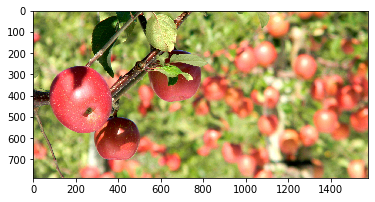

In [6]:
class_name = ['apple', 'strawberry']
image_path = '/content/drive/My Drive/Deep_learning/applstra/val/appl/P2019047.JPG'

image=Image.open(image_path)
plt.imshow(np.array(image))

#評価のための画像下処理

torch.Size([3, 224, 224])


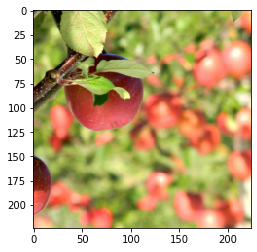

In [9]:
#変形した画像を表示する
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)])
image_transformed = transform(image)
plt.imshow(np.array(image_transformed))

#テンソルに変換してさらにnormalize
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image_tensor = transform(image)

print(image_tensor.shape)


In [10]:
#バッチサイズの次元を先頭に追加した4Dテンソルに変換
image_tensor.unsqueeze_(0)
print(image_tensor.size())  # torch.Size([1, 3, 224, 224])

image_tensor = image_tensor.to(device) #model_ftをGPUに載せる


torch.Size([1, 3, 224, 224])


#モデルにした処理した画像を投入

In [12]:
output = model_ft(Variable(image_tensor))
print(output.size())  # torch.Size([1, 1000])
print(output)

torch.Size([1, 2])
tensor([[ 2.4244, -2.0786]], device='cuda:0', grad_fn=<AddmmBackward>)


#予測結果を表示

In [13]:
_, pred = torch.max(output, 1)
print('Predicted: ', ' '.join('%5s' % class_name[pred]))

Predicted:  a p p l e
